Q 表探索与更新。最优策略即从其中采样的游走。

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

class GridWorld:
    """Simple grid world environment for Q-learning"""
    def __init__(self, size=5):
        self.size = size
        self.state = (0, 0)  # Start position
        self.goal = (size-1, size-1)  # Goal position
        self.obstacles = [(1, 1), (2, 2), (3, 1)]  # Some obstacles
        
    def reset(self):
        """Reset environment to initial state"""
        self.state = (0, 0)
        return self._state_to_index(self.state)
    
    def _state_to_index(self, state):
        """Convert 2D state to 1D index"""
        return state[0] * self.size + state[1]
    
    def _index_to_state(self, index):
        """Convert 1D index to 2D state"""
        return (index // self.size, index % self.size)
    
    def get_valid_actions(self, state):
        """Get valid actions from current state"""
        actions = []
        x, y = state
        # Actions: 0=up, 1=right, 2=down, 3=left
        if x > 0: actions.append(0)  # up
        if y < self.size - 1: actions.append(1)  # right
        if x < self.size - 1: actions.append(2)  # down
        if y > 0: actions.append(3)  # left
        return actions
    
    def step(self, action):
        """Take action and return next state, reward, done"""
        x, y = self.state
        
        # Action mapping: 0=up, 1=right, 2=down, 3=left
        if action == 0 and x > 0:  # up
            next_state = (x-1, y)
        elif action == 1 and y < self.size - 1:  # right
            next_state = (x, y+1)
        elif action == 2 and x < self.size - 1:  # down
            next_state = (x+1, y)
        elif action == 3 and y > 0:  # left
            next_state = (x, y-1)
        else:
            next_state = self.state  # Invalid move, stay in place
        
        # Check if next state is obstacle
        if next_state in self.obstacles:
            next_state = self.state  # Stay in current position
            reward = -1.0  # Penalty for hitting obstacle
        elif next_state == self.goal:
            reward = 10.0  # Reward for reaching goal
        else:
            reward = -0.1  # Small penalty for each step
        
        self.state = next_state
        done = (next_state == self.goal)
        
        return self._state_to_index(next_state), reward, done

class QLearningAgent:
    """Hand-crafted Q-learning agent using PyTorch"""
    def __init__(self, n_states, n_actions, lr=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        
        # Initialize Q-table with PyTorch tensor (25 states x 4 actions)
        self.q_table = torch.zeros((n_states, n_actions), dtype=torch.float32)
        
        # For tracking Q-table evolution
        self.q_history = []
        
    def get_action(self, state, valid_actions):
        """Epsilon-greedy action selection"""
        if random.random() < self.epsilon:
            # Random action from valid actions
            return random.choice(valid_actions)
        else:
            # Greedy action from valid actions
            q_values = self.q_table[state, valid_actions]
            best_action_idx = torch.argmax(q_values).item()
            return valid_actions[best_action_idx]
    
    def update_q_table(self, state, action, reward, next_state, done):
        """Update Q-table using Q-learning update rule"""
        current_q = self.q_table[state, action]
        
        if done:
            target_q = reward
        else:
            next_q_max = torch.max(self.q_table[next_state])
            target_q = reward + self.gamma * next_q_max
        
        # Q-learning update with PyTorch operations
        td_error = target_q - current_q
        self.q_table[state, action] += self.lr * td_error
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save_q_snapshot(self, episode):
        """Save current Q-table snapshot"""
        self.q_history.append({
            'episode': episode,
            'q_table': self.q_table.clone().detach()
        })

def visualize_full_q_table(q_table, title, ax):
    """Visualize complete Q-table as heatmap (25 states x 4 actions)"""
    # Create labels for states and actions
    state_labels = [f'S{i}' for i in range(q_table.shape[0])]
    action_labels = ['Up', 'Right', 'Down', 'Left']
    
    # Create heatmap of the full Q-table
    sns.heatmap(q_table.numpy(), annot=True, fmt='.2f', cmap='viridis',
                xticklabels=action_labels, yticklabels=state_labels,
                ax=ax, cbar_kws={'label': 'Q-value'})
    ax.set_title(title)
    ax.set_xlabel('Actions')
    ax.set_ylabel('States')

def print_q_table_summary(q_table, episode):
    """Print Q-table statistics"""
    print(f"\n=== Q-table Summary (Episode {episode}) ===")
    print(f"Q-table shape: {q_table.shape}")
    print(f"Min Q-value: {torch.min(q_table).item():.3f}")
    print(f"Max Q-value: {torch.max(q_table).item():.3f}")
    print(f"Mean Q-value: {torch.mean(q_table).item():.3f}")
    print(f"Std Q-value: {torch.std(q_table).item():.3f}")

def train_q_learning():
    """Main training loop for Q-learning"""
    # Environment and agent setup
    env = GridWorld(size=5)
    n_states = env.size * env.size  # 25 states
    n_actions = 4  # up, right, down, left
    
    agent = QLearningAgent(n_states, n_actions, lr=0.1, gamma=0.95)
    
    # Training parameters
    n_episodes = 1000
    max_steps_per_episode = 100
    
    # For tracking progress
    episode_rewards = []
    episode_lengths = []
    
    # Episodes to save Q-table snapshots
    snapshot_episodes = [0, 500, 999]
    
    print("Starting Q-learning training...")
    print(f"Q-table initialized with shape: {agent.q_table.shape}")
    
    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        
        for step in range(max_steps_per_episode):
            # Get valid actions for current state
            current_2d_state = env._index_to_state(state)
            valid_actions = env.get_valid_actions(current_2d_state)
            
            # Choose action
            action = agent.get_action(state, valid_actions)
            
            # Take action
            next_state, reward, done = env.step(action)
            
            # Update Q-table
            agent.update_q_table(state, action, reward, next_state, done)
            
            # Update tracking variables
            state = next_state
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        # Decay epsilon
        agent.decay_epsilon()
        
        # Record episode stats
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        # Save Q-table snapshots at specific episodes
        if episode in snapshot_episodes:
            agent.save_q_snapshot(episode)
            print_q_table_summary(agent.q_table, episode)
        
        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            avg_length = np.mean(episode_lengths[-100:])
            print(f"Episode {episode + 1}: Avg Reward = {avg_reward:.2f}, "
                  f"Avg Length = {avg_length:.1f}, Epsilon = {agent.epsilon:.3f}")
    
    return agent, env, episode_rewards, episode_lengths

def visualize_q_evolution(agent):
    """Visualize Q-table evolution (25x4 format only)"""
    n_snapshots = len(agent.q_history)
    
    fig, axes = plt.subplots(1, n_snapshots, figsize=(6*n_snapshots, 8))
    if n_snapshots == 1:
        axes = [axes]
    
    for idx, snapshot in enumerate(agent.q_history):
        title = f"Q-table (Episode {snapshot['episode']})"
        visualize_full_q_table(snapshot['q_table'], title, axes[idx])
    
    plt.tight_layout()
    plt.show()

Starting Q-learning training...
Q-table initialized with shape: torch.Size([25, 4])

=== Q-table Summary (Episode 0) ===
Q-table shape: torch.Size([25, 4])
Min Q-value: -0.522
Max Q-value: 0.000
Mean Q-value: -0.028
Std Q-value: 0.083
Episode 100: Avg Reward = -1.94, Avg Length = 41.5, Epsilon = 0.606
Episode 200: Avg Reward = 7.07, Avg Length = 16.6, Epsilon = 0.367
Episode 300: Avg Reward = 8.42, Avg Length = 12.3, Epsilon = 0.222
Episode 400: Avg Reward = 9.01, Avg Length = 9.4, Epsilon = 0.135
Episode 500: Avg Reward = 9.12, Avg Length = 8.8, Epsilon = 0.082

=== Q-table Summary (Episode 500) ===
Q-table shape: torch.Size([25, 4])
Min Q-value: -0.426
Max Q-value: 10.000
Mean Q-value: 3.394
Std Q-value: 3.408
Episode 600: Avg Reward = 9.19, Avg Length = 8.5, Epsilon = 0.049
Episode 700: Avg Reward = 9.26, Avg Length = 8.3, Epsilon = 0.030
Episode 800: Avg Reward = 9.28, Avg Length = 8.2, Epsilon = 0.018
Episode 900: Avg Reward = 9.27, Avg Length = 8.1, Epsilon = 0.011

=== Q-table S

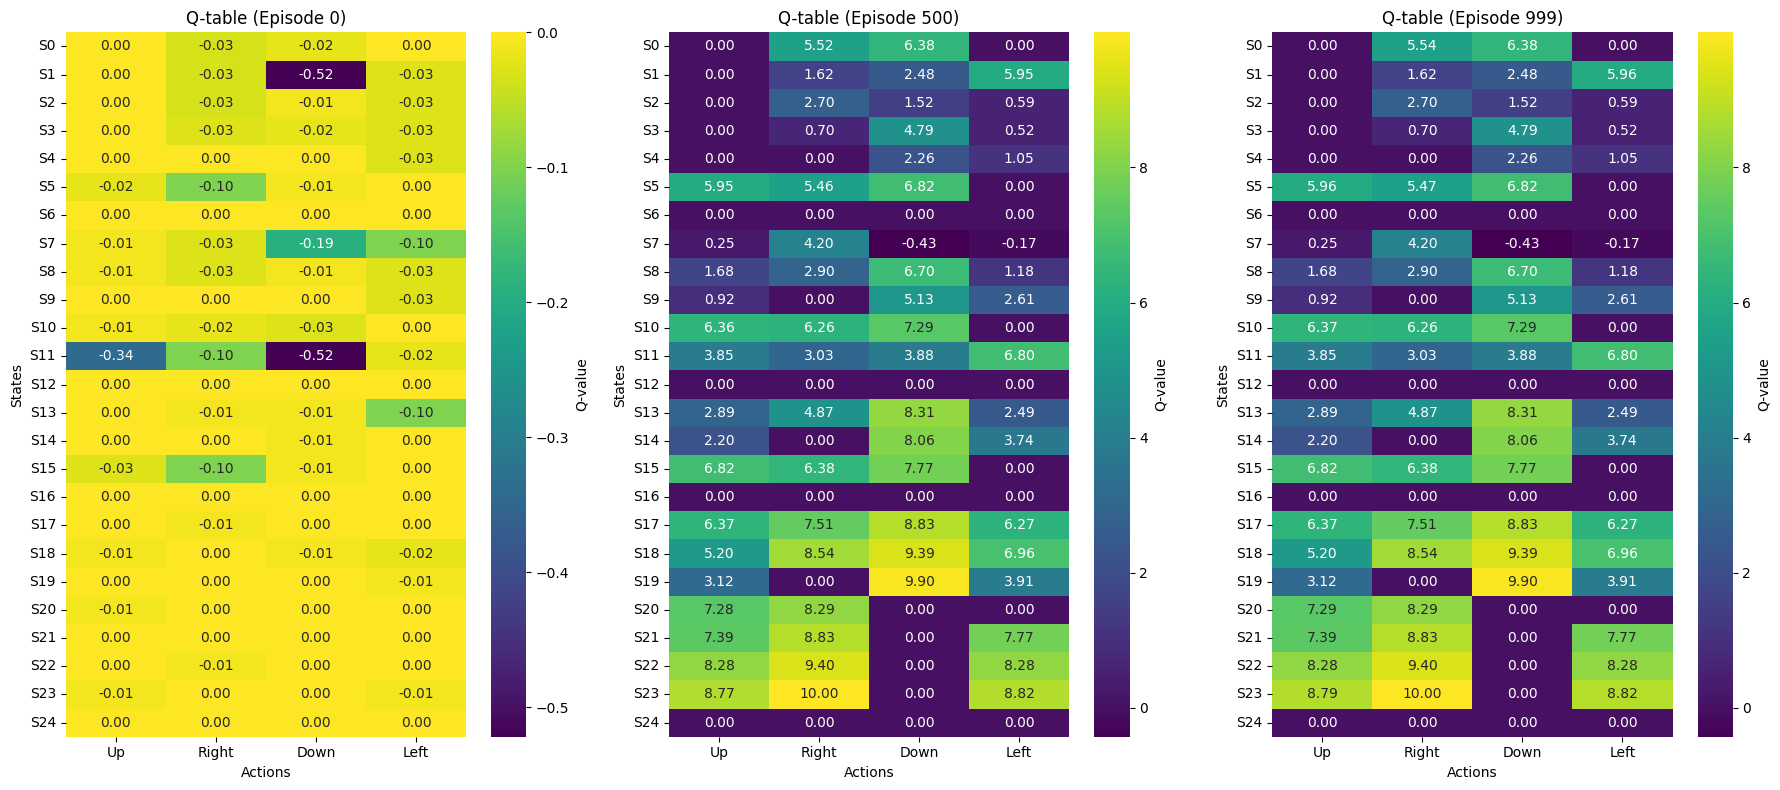

In [20]:
# Train the agent
agent, env, episode_rewards, episode_lengths = train_q_learning()

# Visualize Q-table evolution (25x4 format only)
visualize_q_evolution(agent)

思考 attention map 与 Q 表格的关系和可能的因果性？